# Chapter 3 
## A Tour of machine learning classifiers using scikit-learn

### Choosing a classifier
- no free lunch theorem : no classifier works best across as datasets

5 steps to training a classifier algorithm:
1. Selecting features and collecting labeled data
2. Choosing a performance metric
3. Choosing an algorithm and training a model
4. Evaluating model performance
5. Changing model settings and tuning the model

### Using the perceptron from scikit learn

- note that the three groups of flowers are not linearly seperable
- this is a problem with the perceptron algorithm
    - it will not converge unless the data is linearly seperable

In [1]:
import numpy as np
from sklearn import  datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print(f"Class labels: {np.unique(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 1, stratify = y
)
print(f"Label counts in y: {np.bincount(y)}")
print(f"Labels counts in y_train: {np.bincount(y_train)}")
print(f"Labels counts in y_test: {np.bincount(y_test)}")

sc = StandardScaler().fit(X, y)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

ppn = Perceptron(eta0=0.1, random_state = 1).fit(X_train_std, y_train)
y_predict = ppn.predict(X_test_std)
print(f"Misclassified examples: {(y_test != y_predict).sum()}")
print(f"Accuracy: {ppn.score(X_test_std, y_test)}")

Class labels: [0 1 2]
Label counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]
Misclassified examples: 5
Accuracy: 0.8888888888888888


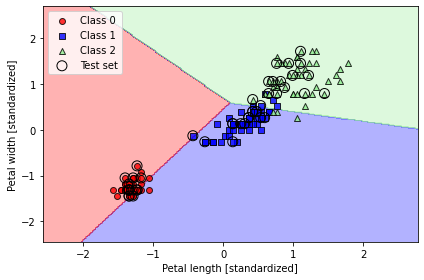

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,resolution=0.02): # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
 
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                        c='none', edgecolor='black', alpha=1.0,
                        linewidth=1, marker='o',
                        s=100, label='Test set')

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Modeling class probabilities using logistic regression

Note that the odds of an event, $p$, is given by $\frac{p}{1-p}$

Let $x$ be a set of features and $y$ be a set of class labels.  Then the conditional probability of the label $y$, given $x$ is $p:=P(y=1|x)$.

Taking the log produces the log-odds function:
$$
    \text{logit}(p) = \log{\frac{p}{1-p}}
$$

$\text{logit}(p)$ maps the probability to $\mathbb{R}$. Assuming that there is a linear relationship between the inputs and the log-odds means:
$$
    \text{logit}(p) = \sum_{i=j} w_jx_j + b = w^Tx + b
$$

However, what is interesting is the probability of class membership given a set of features; the inverse $\text{logit}$ function can be used to produce this probability:
$$
    \sigma(z) = \frac{1}{1 + e^{-z}}
$$
Where $z$ is the new input, just as in the examples in chapter 2.

Note that, as $z \to \infty$, $\sigma(z) \to 1$ because $e^{-z} \to 0$.

#### Logistic regression and Adaline
Just as the adaline algorithm had an activation function, the logistic function has one.  The difference is that logistic regression uses the sigmoid function instead of the identity function. The output of the sigmoid function can then be interpreted as the probability of a class label.  Then the threshold function can be defined as 
$$
    \hat{y} = \left\{
                    \begin{array}{ll}
                        1 & \quad \sigma(z) \geq 0.5 \\
                        0 & \quad \text{otherwise}
                    \end{array}
                \right.
$$
Noting that $\sigma(0) = 0.5$, this is equivalent to: 
$$
    \hat{y} = \left\{
                    \begin{array}{ll}
                        1 & \quad z \geq 0 \\
                        0 & \quad \text{otherwise}
                    \end{array}
                \right.
$$

### Calculating the model weights using the logistic loss function

Note that a logistic regression model is a binary classification.  Then the class label 1 can be thought of as a Bernoulli variable (see [here](https://en.wikipedia.org/wiki/Bernoulli_distribution)), with the probability p being 1 $Y \sim \text{Bern}(p)$ which can be written for the data point $x^{(i)}$:
$$
    P(Y = 1 | X = x^{(i)}) = \sigma(z^{(i)})
$$
and
$$
    P(Y = 0 | X = x^{(i)}) = 1 - \sigma(z^{(i)})
$$

From this the Bernoulli probability mass function can be derived:
$$
    p^k(1-p)^{1-k} = (\sigma(z^{(i)}))^{y^{(i)}} (1 - \sigma(z^{(i)}))^{1 - y^{(i)}}
$$
(where $k \in \{ 0,1 \}$). Then the probability that all events occur (the likelihood) is derived from the multiplication rule (noting that the class labels are independent):
$$
    \mathscr{L}(w, b | x) = \prod_{i=1}^n (\sigma(z^{(i)}))^{y^{(i)}} (1 - \sigma(z^{(i)}))^{1 - y^{(i)}}
$$

Generally the log is taken to make the log-liklihood function so that the product becomes a summation and exponents become multiplication (recall log laws), in addition to making the derivative easier to calculate via the addition rule:
$$
    \log \mathscr{L}(w, b | x) = \sum_{i=1}^n y^{(i)}(\log\sigma(z^{(i)})) + (1 - y^{(i)})\log(1 - \sigma(z^{(i)}))
$$

In order to write this as the loss function by multiplying by -1:
$$
    L(w, b) = \sum_{i=1}^n -y^{(i)}(\log\sigma(z^{(i)})) - (1 - y^{(i)})\log(1 - \sigma(z^{(i)}))
$$

Now consider the loss for a single training example:
$$
    L(\sigma(z^{(i)}), y; w, b) = -y\log(\sigma(z)) - (1 - y)\log(1 - \sigma(z))
$$
It is clear that:
$$L(\sigma(z^{(i)}), y; w, b) = \left\{
                    \begin{array}{ll}
                        -\log(\sigma(z)) & \quad \text{if } y = 1 \\
                        -\log(1-\sigma(z)) & \quad \text{if } y = 0
                    \end{array}
                \right.
$$

The loss approaches zero if the prediction is correct, and approaches inifinity if the prediction is incorrect.

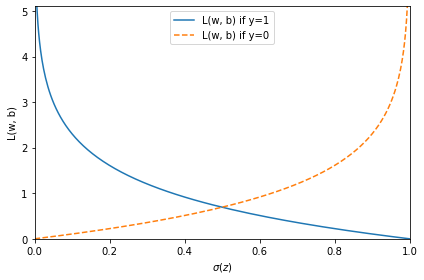

In [3]:
def plot_loss():
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def loss_1(z):
        return - np.log(sigmoid(z))
    
    def loss_0(z):
        return - np.log(1 - sigmoid(z))
    
    z = np.arange(-10, 10, 0.1)
    sigma_z = sigmoid(z)
    c1 = [loss_1(x) for x in z]
    plt.plot(sigma_z, c1, label='L(w, b) if y=1')
    c0 = [loss_0(x) for x in z]
    plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
    plt.ylim(0.0, 5.1)
    plt.xlim([0, 1])
    plt.xlabel('$\sigma(z)$')
    plt.ylabel('L(w, b)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
plot_loss()

### Implementing the logistic regression

The only difference between Adaline integration and logistic regression is the activiation function

In [4]:
class LogisticRegressionGD:
    
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):
        self.eta = eta #learning rate
        self.n_iter = n_iter #number of epochs
        self.random_state = random_state #random state to initialize weights
        
    def fit(self, X, y):
        #X is a collection of training vectors and y is a collection of correct classifications
        #set initial weight and bias unit
        rgen = np.random.RandomState(self.random_state)
        # initialize weights as small, normally distributed, random values
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        #bias unit is set to zero initially
        self.b_ = np.float_(0.)
        #list to hold the loss function outputs
        self.losses_ = list()
        #move through the epochs
        for i in range(self.n_iter):
            #calculate the net input (i.e. z)
            net_input = self.net_input(X)
            #calculate the loss via the activation function
            output = self.activation(net_input)
            #calculate error as how far off the activation function was
            errors = y - output
            #update weights
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            #update bia unit
            self.b_ += self.eta * 2.0 * errors.mean()
            #calculate the loss
            loss = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0])
            #add to the loss list
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        #calculates teh dot product to get the z for the decision function
        return np.dot(X, self.w_) + self.b_
    
    # THIS IS THE ONLY FUNCTION THAT IS DIFFERENT
    def activation(self, z):
        #activation for logistic regression is the sigmoid function
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        #the decision function
        return np.where(self.net_input(X) >= 0.5, 1, 0)

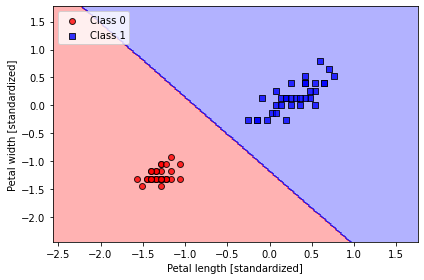

In [5]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3,
    n_iter=1000,
    random_state=1)
lrgd.fit(X_train_01_subset,
    y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
    y=y_train_01_subset,
    classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Logistic Regression in Scikit-learn

- by default will use multinomial for multiclassification

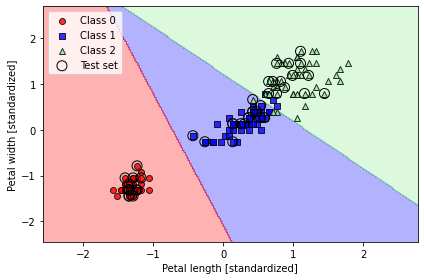

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
#predict proba will give the output of the sigmoid function
lr.predict_proba(X_test_std[:3, :])

array([[3.75921857e-09, 1.44746713e-01, 8.55253283e-01],
       [8.34050709e-01, 1.65949291e-01, 2.79885839e-13],
       [8.48851960e-01, 1.51148040e-01, 2.22264680e-14]])

In [8]:
#these correspond to class labels
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [9]:
#we can access the class label prediction directly using predict
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [20]:
#to predict a single record, scikit still expects a 2 dimenstion array
print(f"One record array: {X_test_std[0, :]}")
print(f"One record array shape: {X_test_std[0, :].shape}")
print(f"Use reshape to make 2d: {X_test_std[0, :].reshape(1, - 1)}")
print(f"New array shape: {X_test_std[0, :].reshape(1, - 1).shape}")
#make a prediction
lr.predict(X_test_std[0, :].reshape(1, -1))

One record array: [0.93327055 1.44883158]
One record array shape: (2,)
Use reshape to make 2d: [[0.93327055 1.44883158]]
New array shape: (1, 2)


array([2])

### Tackling overfitting via regularization
- [wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics))
- a common problem with models is *overfitting* which means that a model has too high variance and therefore does not generalize well to unseen data
- opposite problem, *underfitting*, is caused when there is too high bias
- *variance* : the consistency of a prediction when the model is retrained multiple times (for example on subsets of the training set). This is a measure of sensitivity to the randomness in a training set
- *bias* : measure of systemic error that is not due to randomness. It is a measure of how far off the prediction is if the model is rebuilt using multiple subsets of the training dataset
- there is a general *bias-variance tradeoff*
- a way to make a good tradeoff is to use *regularization* which adds information to penalize extreme weight values
- a common one is **L2 regularization** written as follows:
$$
    \frac{\lambda}{2n}\|w\|^2 = \frac{\lambda}{2n}\sum_{j=1}^m w_j^2
$$
- λ is the *regularization parameter* and n is the sample size  recall the double bars are the [vector norm](https://mathworld.wolfram.com/VectorNorm.html)
- note that regularization requires standardization of all the features
- the regularization is added to the loss function:
$$
    L(w, b) = \frac{1}{n}\sum_{i=1}^n [-y^{(i)}(\log\sigma(z^{(i)})) - (1 - y^{(i)})\log(1 - \sigma(z^{(i)}))] + \frac{\lambda}{2n}\|w\|^2
$$
- the new partial derivative becomes ([derivative of a vector norm info](https://math.stackexchange.com/questions/296697/differentiation-of-vector-norms)):
$$
    \frac{\partial L(w, b)}{\partial w} = \left(\frac{1}{n} \sum_{i=1}^n (\sigma(w^Tx^{(i)}) - y^{(i)})x_j^{(i)}\right) + \frac{\lambda}{n}w_j
$$
- λ allows us to control the fit to the training data; an high value for λ increases regularization 

#### Regularization parameter and C
- the `C` parameter is inversely proportional to λ
- a decrease in `C` is therefore an increase in regularization strength

Note that if a dataset is over regularized, the model will consequently be underfit

## Maximum margin classification with support vector machines
- *support vector machines* are considered an extension of the perceptron
- however, instead of minimizing classification errors, SVMs try to maximize the margin
    - *margin* is the distance from the decision boundary hyperplane and training points nearest to this hyperplane
    - the nearest training points are called *support vectors*
- SVMs use a slack variable for *soft-margin classification* allows for convergence optimization in nonlinearly seperable data due to giving "slack" to misclassifications under a loss penalization
- This hyperparameter is `C`, which controls this penalization of misclassifications; a higher `C` value results in large error penalities

### SVM in scikit-learn

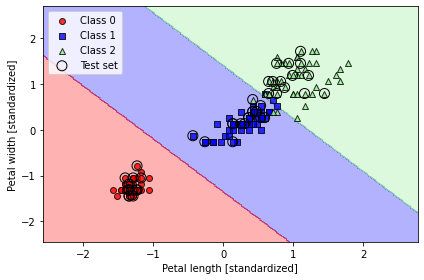

In [21]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### SVMs vs Logistic regression
- Logistic Regression tends to be prone to outliers because it maximizes conditional likelihoods
- SVMs focus on points closest to the decision boundary (support vectors) and therefore are not sensitive to outliers
- both perform similarly on data
- logistic regression is mathematically simpler
- logistic regression is easier to update, for example in stream data

## LIBLINEAR and SGDClassifier
- [website](https://www.csie.ntu.edu.tw/~cjlin/liblinear/)
- this is a C/C++ optimized library which allows for quicker computing
- for data that does not fit into memory, scikit-learn `linear_model.SGDClassifier` (**S**tochastic **G**radient **D**escent) allows for the `partial_fit` method to use in online learning
- The three above models can be implemented using the `loss` parameter, thusly:
    - `perceptron`
    - `log` (logistic regression)
    - `hinge` (SVM)

## nonlinear problems and kernel SVMs
- SVMs can be *kernalized* to solve non-linear classification problems

### kernel methods and kernal trick
- *kernel methods* map non-linearly seperable data into a higher dimension where they become linearly seperable
- consider the following example projection from $\mathbb{R}^2$ into $\mathbb{R}^3$:
$$
    \phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2+ x_2^2)
$$
- this allows for a plane to seperate the groups, moreover $\phi$ is bijective
- a projection then could be applied to unseen data and then apply the model

#### kernel trick
- However, this is computationally expensive, but we can replace the $z$ dot product with the mapping:
$$
    (x^{(i)})^Tx^{(j)} \to \kappa(x^{(i)}, x^{(j)}) = \phi((x^{(i)})^T)\phi(x^{(j)})
$$
- this new function is called the *kernel function*
- a common one is the Gaussian kernel (*radial basis function*):
$$
    \kappa(x^{(i)}, x^{(j)}) = \text{exp}\left( - \frac{\|x^{(i)} - x^{(j)}\|^2}{2\sigma^2}\right) = \text{exp}\left(-\gamma\|x^{(i)} - x^{(j)}\|^2\right)
$$
where $\gamma = \frac{1}{2\sigma^2}$
- this can them be interpreted as a *similarity function* between a pair of examples with a range of 1 (similar) to 0 (dissimilar)

#### information on the gaussian function
- [Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function) : this creates a bell curve like graph where $c$ is controls the width of the bell (the standard deviation)
- [desmos graph](https://www.desmos.com/calculator/hs6flbwkka) interactive
- [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function)


consider the following data:

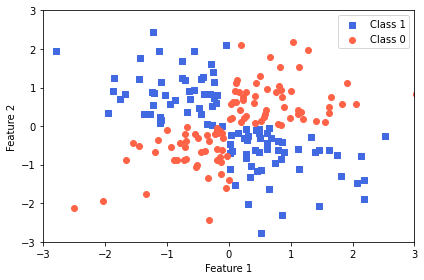

In [23]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o', label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Using the kernel function `kernel='rbf'` in scikit-learn's Support Vector classifier:

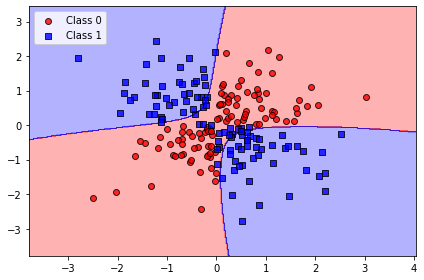

In [24]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Note that `gamma` is the parameter that acts as a cut off point for the gaussian sphere. As `gamma`increases, there is less variance and the model fits closer to the data [see desmos graph](https://www.desmos.com/calculator/6pntlw7w9m).  Therefore `gamma` / $\gamma$ is crucial to controlling overfitting

## Decision Tree learning
- data is split based on the highest *information gain (IG)*
- to prevent overfitting, a decision tree is *pruned* by limiting the max depth of the tree
- more information on [tree data structure](https://en.wikipedia.org/wiki/Tree_(data_structure))
- information on [binary trees](https://en.wikipedia.org/wiki/Binary_tree)
- [converting n-array tree to a binary](https://examradar.com/converting-m-ary-tree-general-tree-binary-tree/)
    - note that there is a one-to-one mapping of generic trees to binary trees!

The objective function to be maximized is below:
$$
    IG(D_p, f) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p}I(D_j)
$$
where:
1. $f$ is the feature to perform the split; 
2. $D_p$ is the data set of the parent node; 
3. $D_j$ is the data set of the jth child node;
3. $I$ is the *impurity* measure; 
4. $N_p$ is the total number of training examples at the parent node
5. $N_j$ is the total number of training examples at the jth child node
6. $m$ is the number of nodes

Note that the *information gain* function is the difference between the impurity of the parent node, minus the impurity of the child node.  This is the function that we want to *maximize*

For ease of calculation and simplicity, scikit-learn uses a binary tree:
$$
    IG(D_p, f) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) -  \frac{N_{right}}{N_p}I(D_{right})
$$

### Impurity measures / splitting criteria

Three major types:
1. *Gini impurity* $I_G$
2. *entropy* $I_H$
3. *classification error $I_E$

#### Entropy
$$
    I_H(t) = - \sum_{i=1}^c p(i|t) \log_2p(i|t)
$$
Where $p(i|t)$ is the proportion of class $i$ for node $t$ and $c$ is the number of classes.  This implies an entropy of 0 if all the node is the same class (therfore, low impurity and no information gain); entropy is maximal for uniform class distribution on the node.  Note that in terms of maximizing the objective function, a node that has an entropy of 0 is more valuable; because then there is a clear classification rule for that class. Entropy therefore maximizes the mutual information in the tree.

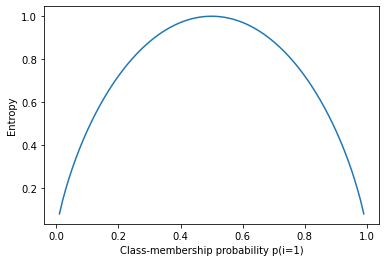

In [25]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)
plt.show()

#### Gini Impurity
$$
    I_G(t) = \sum_{i=1}^c p(i|t)(1-p(i|t)) = 1 - \sum_{i=1}^c p(i|t)^2
$$
[more information](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)
Note that $ \sum p(i|t) = 1$ because it simply counts all of the proportions for each class in the dataset.  Note that Gini impurity is maximized when there is uniform class distribution at a node; therefore results are similar to $I_H$. Generally the a better way to improve a decision tree is through pruning.

#### Classification Error
$$
    I_E(t) = 1 - \text{max}\{p(i|t)\}
$$
Note that this is less sensitive to changes in $p(i|t)$. Note that a parent node with (40, 40) class distribution can have the same IG when split as (30, 10) and (10, 30) as when it is split (20, 40) and (40, 20).

### Graph of impurity functions
- note that Gini is a compromise between entropy and classification

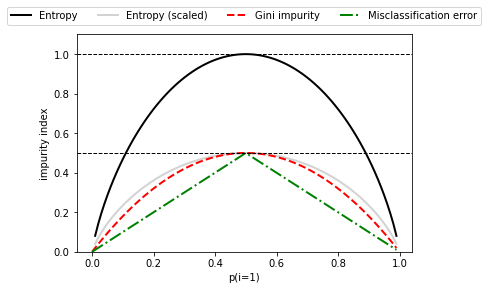

In [29]:
def gini(p):
    return p*(1 - p) + (1 - p)*(1 - (1-p)) 
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x] 
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                        ['Entropy', 'Entropy (scaled)', 'Gini impurity', 'Misclassification error'],
                        ['-', '-', '--', '-.'],
                        ['black', 'lightgrey', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--') 
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--') 
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index') 
plt.show()

## Using a decision tree in scikit-learn
- decision trees can overfit, this is prevented by tuning to the depth of the tree
- feature scaling is not needed for decision trees; the optimization is not based on the scale of the datapoints
- the decision tree divides the space into rectangles

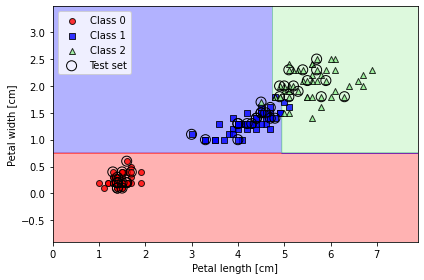

In [30]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1) 
tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105, 150)) 
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The decision tree itself can be visualized. Left branches are 'true' and right are 'false'

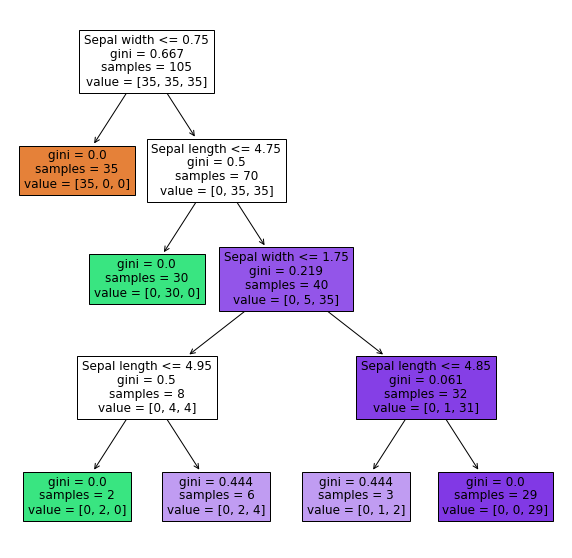

In [34]:
from sklearn import tree
plt.figure(figsize=(10,10))
feature_names = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width'] 
tree.plot_tree(tree_model, feature_names=feature_names, filled=True) 
plt.show()

## Combining decision trees via random forest
Random forest ensemble models uses a series of decision trees that have high variance, but which together are more robust to overfitting.

The algorithm for random forests is as follows:
1. Draw a random bootstrap sample of size n.
    - *bootstrap*: n examples with replacement
2. Grow a decision tree from bootstrap sample. At each node:
    1. select d features without replacement
    2. split nodes using features that maximize the $IG$ function
3. Repeat steps 1 and 2 $k$ times
4. Aggregate predictions by a majority vote

Generally the only hyperparameter that is meaningful is $k$, the number of trees.  Note that the higher the number of trees, the better the performance, but at a high computational cost.

Choosing the number of samples, $n$, can increase randomness in the model and preven overfitting; however, smaller values reduce overall performance. A choice of the number of features, $d$, is usually $d = \sqrt{m}$ where $m$ is the number of features in the dataset.

Scikit-learn has a `n_jobs` parameter which allows allows for use of multiple CPU cores.

## K-nearest neighbors
K-nearest neighbors is considered a *lazy learner* because it does not produce a decision function, but memorizes the training data instead. This means that is is *non-parametric* and *instance-based*; in constrast, *parametric* models use a function to classify new data without needing the training data.

The K-nearest neighbors uses the following algorithm:
1. Choose $k$ and a distance metric
2. Find the $k$ nearest datapoints
3. Assign a label by majority vote

Note that to decrease computational stress, datastructures like `k-d tree` and `ball tree` are used in scikit learn to query the training data.  However, large data sets still require significant storage capacity regardless of more efficient algorithms. 

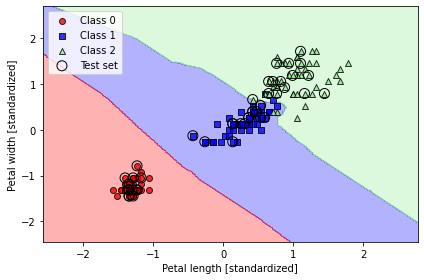

In [35]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105,150)) 
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Note the smoothness of the decision boundary

The right choice of $k$ is crucial to the algorithm, along with the choice of distance metric.  When using real valued data which has been standardized, Euclidean distance works well. Note that the Minkowski distance:
$$
    d(x^{(i)}, x^{(j)}) = \sqrt[p]{\sum_k |x_k^{(i)} - x_k^{(j)}|^p}
$$
is equal to the Euclidean distance when $p=2$.  Minkowski distance is a generalization of the Euclidean and Manhattan distance (equivalent to Manhattan distance when $p=1$).

K-nearest neighbors suffers from the *curse of dimensionality* because at higher dimensions, the data may not be dense enough for a good classification.  Note that regularization will not help with overfitting; however, feature selection and dimension reduction will help.